<a href="https://colab.research.google.com/github/pritiyadav888/Machine-Learning-Projects/blob/main/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NLP PROJECT - SENTIMENT ANALYSIS ON MUSICAL INSTRUMENTS



# Environment settings

In [ ]:
!pip install wordcloud

## Libraries

In [ ]:
# Basic Imports
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from textblob import Word, TextBlob
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
import string
import collections
import matplotlib.cm as cm

In [ ]:
# Pandas settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Loading the data

In [ ]:
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

#Importing dataset
df = getDF('/Users/priti/Dropbox/Semester 4/NLP/reviews_Musical_Instruments_5.json.gz')

<b>1. Dataset data exploration: List the main finding of the dataset. Be thorough and creative. <br>
For example, look at: <br>
a. Counts, averages <br>
b. Distribution of the number of reviews across products <br>
c. Distribution of the number of reviews per product <br>
d. Distribution of reviews per user <b>

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10261 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 801.6+ KB


<b>Total columns- 9 <br> Total observations 10261<b>

In [ ]:
# Top 5 rows
df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exac...",5.0,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]",The product does exactly as it should and is q...,5.0,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]",The primary job of this device is to block the...,5.0,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and preven...,5.0,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and perform...,5.0,No more pops when I record my vocals.,1392940800,"02 21, 2014"


In [ ]:
# Unique products
asin_unique = len(df["asin"].unique())
print("Number of Unique ASINs: " + str(asin_unique))

Number of Unique ASINs: 900


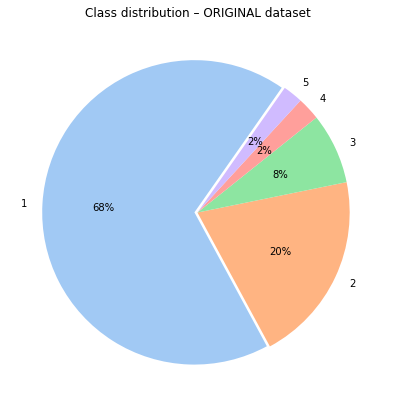

In [ ]:
# Plotting class distribution
class_counts = df['overall'].value_counts()
class_labels = ['1', '2', '3', '4', '5']
colors = sns.color_palette('pastel')
explode = (0.02, 0, 0, 0, 0)  
plt.figure(figsize=(7, 7))
plt.pie(class_counts, labels=class_labels, colors=colors, explode=explode, autopct='%.0f%%', startangle=55)
plt.title('Class distribution – ORIGINAL dataset')
plt.show()

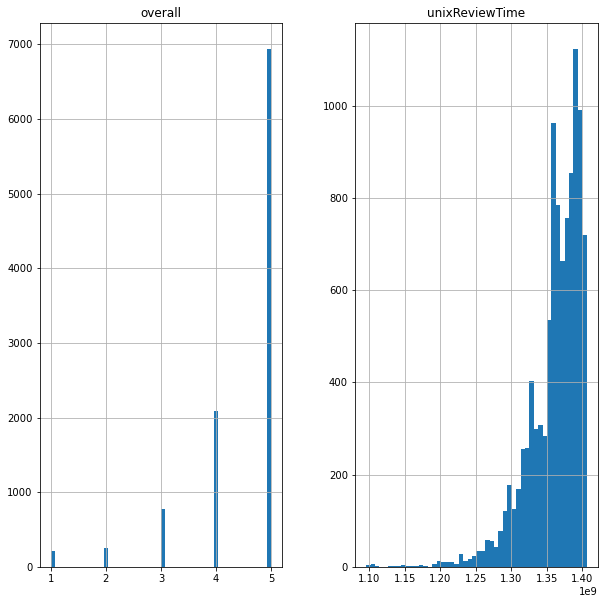

In [ ]:
# Builds histogram and set the number of bins and fig size (width, height)
df.hist(bins=50, figsize=(10,10))
plt.show()

In [ ]:
# Checking how many uniques ReviewerName and Asin
len(df["reviewerName"].unique()), len(df["asin"].unique())

(1398, 900)

In [ ]:
# Analysis of rating given by the user
no_of_rated_products_per_user = df.groupby(by='reviewerID')['overall'].count().sort_values(ascending=False)
no_of_rated_products_per_user.head()

reviewerID
ADH0O8UVJOT10     42
A1L7M2JXN4EZCR    38
A15TYOEWBQYF0X    38
A2EZWZ8MBEDOLN    36
A2NYK9KWFMJV4Y    34
Name: overall, dtype: int64

In [ ]:
# Rows having duplicate value
print("Number rows having common values of [reviewerName, reviewText, unixReviewTime] =", 
      df[df.duplicated(subset=["reviewerName", "reviewText", "unixReviewTime"])].shape[0])

Number rows having common values of [reviewerName, reviewText, unixReviewTime] = 0


In [ ]:
# Checking amount of null values
df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

reviewerName has 27 null values. 

In [ ]:
# Drop null values
df.drop_duplicates(subset ="reviewText", keep = "first", inplace = True)

In [ ]:
df.describe()

,overall,unixReviewTime
count,10255.000000,1.025500e+04
mean,4.488542,1.360617e+09
std,0.894820,3.779029e+07
min,1.000000,1.095466e+09
25%,4.000000,1.343520e+09
50%,5.000000,1.368490e+09
75%,5.000000,1.388966e+09
max,5.000000,1.405987e+09


In [ ]:
# Total count of reviews per overall
df['overall'].value_counts()

5.0    6933
4.0    2083
3.0     772
2.0     250
1.0     217
Name: overall, dtype: int64

In [ ]:
# Overall value counts 
df['overall'].value_counts(normalize=True)

5.0    0.676060
4.0    0.203120
3.0    0.075280
2.0    0.024378
1.0    0.021160
Name: overall, dtype: float64

<b>Text basic pre-processing: <br> 
a. Randomly select 500-1000 reviews from your dataset and perform steps b 
through d.  <br> 
b. Label your data based on the value of “rating of the product” i.e. as follows:  <br> 
i. Ratings 4,5:  Positive   <br> 
ii. Rating      3:   Neutral  <br> 
iii. Ratings  1,2: Negative<b>

In [ ]:
# df_Sample_full = df.copy()

In [ ]:
df_Sample = df.groupby('overall', group_keys=False).apply(lambda x: x.sample(200))

In [ ]:
# Dropping columns
col_to_drop = ['reviewerID', 
               'asin', 
               'reviewerName',
               'helpful',
               'unixReviewTime',
               'reviewTime']
df_Sample.drop(col_to_drop, axis = 1, inplace=True)

In [ ]:
df_Sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 9047 to 8643
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   reviewText  1000 non-null   object 
 1   overall     1000 non-null   float64
 2   summary     1000 non-null   object 
dtypes: float64(1), object(2)
memory usage: 31.2+ KB


In [ ]:
df_Sample

,reviewText,overall,summary
9047,I ordered 1 just to try it since it was so che...,1.0,broke
223,"Received it in time, standard blister packagin...",1.0,DIED after 45 days of use
8555,"Really wanted to like this one, because I love...",1.0,"Not true bypass, colors tone/breaks easily."
8520,This unit might be great if you have child han...,1.0,What a joke
8077,"At the time I bought, was $16. Mine arrived b...",1.0,"Poorly Made, Flimsy. Buy Another Product"
...,...,...,...
4593,Just bought this to see if it would inspire an...,5.0,LOVE IT!
3782,"As musicians, sometimes we find just the right...",5.0,"PRICELESS !!! My ""Capo Quest"" is over !!!"
1147,I have a cedar topped acoustic and these strin...,5.0,Wow! Volume!
8041,A perfect sounding string! The crisp ring the...,5.0,Aquila Soprano Ukulele Strings


In [ ]:
import numpy as np

# labeling data based on the value of rating of the product
conditions = [
    df_Sample.overall >= 4.0,
    df_Sample.overall == 3.0,
    df_Sample.overall <= 2.0,
]

values = ['Positive', 'Neutral', 'Negative']

df_Sample['Ratings'] = np.select(conditions, values)

<b>Chose the appropriate columns for your sentiment analyzer. (Give this some 
thought<b>

Combining summary with reviewText in df_Sample, df_only_reviewText keeping reviewText copy in case want to run model without summary

In [ ]:
# Using + operator to combine two columns
df_Sample["reviewText"] = df_Sample['reviewText']+ df_Sample["summary"]

In [ ]:
# Removing summary column
del df_Sample['summary']

In [ ]:
# # Class from features separated.
# df_features = df_Sample.drop('overall', axis=1)
# df_class = df_Sample['overall']

In [ ]:
df_Sample

,reviewText,overall,Ratings
9047,I ordered 1 just to try it since it was so che...,1.0,Negative
223,"Received it in time, standard blister packagin...",1.0,Negative
8555,"Really wanted to like this one, because I love...",1.0,Negative
8520,This unit might be great if you have child han...,1.0,Negative
8077,"At the time I bought, was $16. Mine arrived b...",1.0,Negative
...,...,...,...
4593,Just bought this to see if it would inspire an...,5.0,Positive
3782,"As musicians, sometimes we find just the right...",5.0,Positive
1147,I have a cedar topped acoustic and these strin...,5.0,Positive
8041,A perfect sounding string! The crisp ring the...,5.0,Positive


<b>Pre-processing<b>

In [ ]:
import re
import numpy as np

def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text
#Removing punctuations
import string

def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text
df_Sample['Pre_Processed_text'] = np.vectorize(remove_pattern)(df_Sample['reviewText'], "@[\w]*")
df_Sample['Pre_Processed_text'] = df_Sample['Pre_Processed_text'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
df_Sample['Pre_Processed_text'] = df_Sample['Pre_Processed_text'].apply(lambda x: re.split('#(\w+)', str(x))[0])
df_Sample["Pre_Processed_text"] = df_Sample["Pre_Processed_text"].str.lower()
df_Sample['Pre_Processed_text'] = df_Sample['Pre_Processed_text'].str.replace(' \b\d+\b', " ")
df_Sample["Pre_Processed_text"] = df_Sample['Pre_Processed_text'].apply(lambda x: remove_punct(x))

Added custom list for the negation words to keep in "pre-processed text" as not_stopwords a nd removed them from the nltk stopwords library

In [ ]:
import nltk
from nltk.corpus import stopwords
sw_nltk = stopwords.words('english')
# print(sw_nltk)
not_stopwords = {'not', 'no', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",'don', "don't"} 
final_stop_words = set([word for word in sw_nltk if word not in not_stopwords])
print(final_stop_words)


{'was', 'it', 'until', "she's", 'ours', 'where', 'your', 'each', 'before', 'own', 'with', 'some', 'who', 'few', 'hers', 'do', 'have', 're', 'if', 'are', 'the', 'at', 'too', 'm', 'o', 'and', 'i', 'over', 'should', 'is', 'did', 'she', 'yourselves', 'all', 'same', 'yourself', 'they', 'be', 'their', 'how', 'd', 'he', 'were', 'has', 'this', 'its', 'on', 'after', 'which', 'because', 'here', 'between', 'me', "it's", 'doing', 'from', 'yours', 'herself', 'down', 'during', 'had', 'but', 'of', "you're", 'being', 'himself', 'about', 'below', 'nor', "you've", 'her', 'into', 'so', 'why', 'his', 'again', 'will', 'ourselves', 'in', 'only', 'or', 'most', "you'll", 'am', 'under', 'an', 've', 'by', 'him', 'does', 'them', 'than', 'other', 'off', 'more', 'very', 'you', 'these', 'having', 'both', 'been', 'now', 'll', 'what', 'to', 'our', 'up', 'y', 'a', 'out', 'such', 's', 'further', 'those', 'there', 'while', 'myself', "should've", 'for', 't', 'itself', 'whom', 'can', 'as', 'that', "that'll", 'just', 'we',

In [ ]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

def preprocess(sentence):
    sentence=str(sentence)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in final_stop_words]
    stem_words=[stemmer.stem(w) for w in filtered_words]
    lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
    return " ".join(filtered_words)


df_Sample['Pre_Processed_text']=df_Sample['Pre_Processed_text'].map(lambda s:preprocess(s)) 

Pre Processed data after stopwords, stemming and lemmetization

In [ ]:
df_Sample['Pre_Processed_text']

9047    ordered try since cheap first one arrived non ...
223     received time standard blister packaging cable...
8555    really wanted like one loved price way true by...
8520    unit might great child hands keys keyboard soo...
8077    time bought mine arrived broken gone back real...
                              ...                        
4593    bought see would inspire new sounds wow love c...
3782    musicians sometimes find right sound feel piec...
1147    cedar topped acoustic strings brought life wit...
8041    perfect sounding string crisp ring strings giv...
8643    may experienced problems musicians drummer dru...
Name: Pre_Processed_text, Length: 1000, dtype: object

<b>Negative word cloud visualization<b>

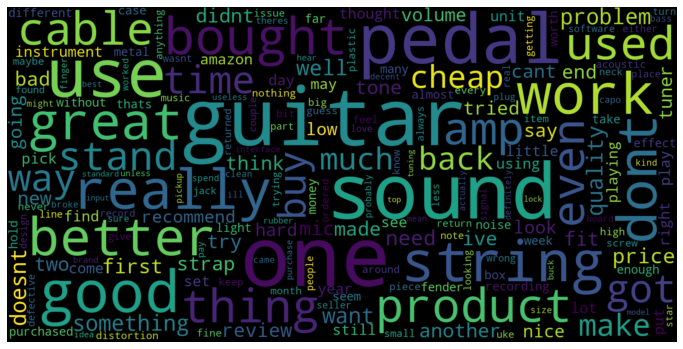

In [ ]:
neg_reviews = df_Sample[df_Sample.Ratings == 'Negative']
neg_string = []
for t in neg_reviews.Pre_Processed_text:
    neg_string.append(t)
neg_string = pd.Series(neg_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Positive word cloud visualization<b>

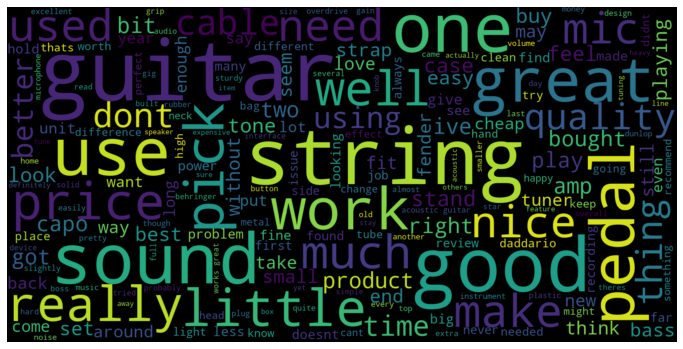

In [ ]:
pos_reviews = df_Sample[df_Sample.Ratings == 'Positive']
pos_string = []
for t in pos_reviews.Pre_Processed_text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<b>Neutral word cloud visualization<b>

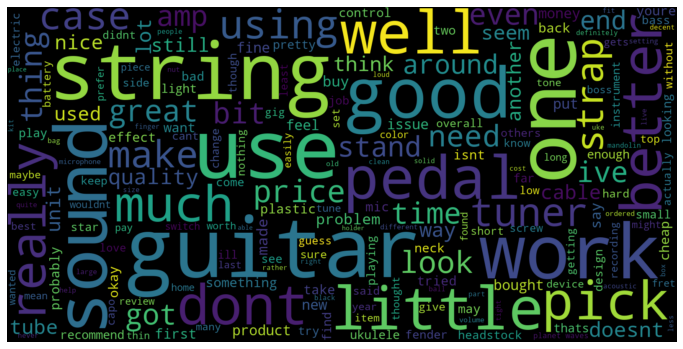

In [ ]:
neu_reviews = df_Sample[df_Sample.Ratings == 'Neutral']
neu_string = []
for t in neu_reviews.Pre_Processed_text:
    neu_string.append(t)
neu_string = pd.Series(neu_string).str.cat(sep=' ')


wordcloud = WordCloud(width=1600, height=800,max_font_size=200).generate(neu_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Stratified Sampling

Split the data into 70% for training and 30% for testing,—Use stratified splitting 
based on the rating value field.

In [ ]:
y = df_Sample['overall']

In [ ]:
# Applying Stratfied Shuffle
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(df_Sample, y):
    strat_train_set = df_Sample.iloc[train_index]
    strat_test_set = df_Sample.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test = y.iloc[test_index]

In [ ]:
print(strat_train_set.head())
print(strat_test_set.info())

                                             reviewText  overall   Ratings                                 Pre_Processed_text
8089  I use to have a guitar that sounded horrible w...      3.0   Neutral  use guitar sounded horrible thing pain take ho...
4611  It is a nice smaller version of the 114SI Road...      3.0   Neutral  nice smaller version road proit would great st...
5638  For years I was lugging around a large rack ca...      4.0  Positive  years lugging around large rack case mackie bo...
7778  There's no substitute for the right part. Thes...      4.0  Positive  theres substitute right part great like extras...
7814  I use these and the next heavier and have sinc...      5.0  Positive  use next heavier since came standard model gre...
<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 4801 to 6533
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewText          300 non-null 

In [ ]:
# Checking stratified train
strat_train_set['overall'].value_counts(normalize=True)

3.0    0.2
4.0    0.2
5.0    0.2
2.0    0.2
1.0    0.2
Name: overall, dtype: float64

In [ ]:
# Checking stratified test
strat_test_set['overall'].value_counts(normalize=True)

4.0    0.2
1.0    0.2
5.0    0.2
3.0    0.2
2.0    0.2
Name: overall, dtype: float64

In [ ]:
strat_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300 entries, 4801 to 6533
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewText          300 non-null    object 
 1   overall             300 non-null    float64
 2   Ratings             300 non-null    object 
 3   Pre_Processed_text  300 non-null    object 
dtypes: float64(1), object(3)
memory usage: 11.7+ KB


In [ ]:
print("TRAIN:\n", strat_train_set, "\nTEST:", strat_test_set)

TRAIN:
                                              reviewText  overall   Ratings                                 Pre_Processed_text
8089  I use to have a guitar that sounded horrible w...      3.0   Neutral  use guitar sounded horrible thing pain take ho...
4611  It is a nice smaller version of the 114SI Road...      3.0   Neutral  nice smaller version road proit would great st...
5638  For years I was lugging around a large rack ca...      4.0  Positive  years lugging around large rack case mackie bo...
7778  There's no substitute for the right part. Thes...      4.0  Positive  theres substitute right part great like extras...
7814  I use these and the next heavier and have sinc...      5.0  Positive  use next heavier since came standard model gre...
...                                                 ...      ...       ...                                                ...
3145  I can't believe these were actually sent to me...      1.0  Negative  cant believe actually sent heads s

<b>Text representation: Represent your text using one of the approaches explained in 
module . Justify why you chose that approach<b>

We are using BOW and TF-IDF in machine learning approach. The Bag of Words model simply generates a set of vectors holding the count of word occurrences in the text (reviews), while the TF-IDF model includes information on both the more significant and less important words. The Bag of Words vectors are simple to understand. TF-IDF, on the other hand, frequently outperforms TF-IDF in machine learning models. Also, Only the first few words(20) were used in the Word embedding approach, whereas the TF-IDF method used all available words.<br><b>Please scroll down and check the Meachine learning approach section.<b>

### Lexicon Based Approach for Sentiment Analysis

### Textblob

In [ ]:
# Applying TextBlob
from textblob import TextBlob
from textblob.classifiers import NaiveBayesClassifier

In [ ]:
strat_train_df = strat_train_set.drop(strat_train_set.columns[[0,1]], axis=1) # dropping asin and overall
strat_train_df = strat_train_df[['Pre_Processed_text', 'Ratings']] # this is needed for changing columns order

In [ ]:
strat_train_df

,Pre_Processed_text,Ratings
8089,use guitar sounded horrible thing pain take ho...,Neutral
4611,nice smaller version road proit would great st...,Neutral
5638,years lugging around large rack case mackie bo...,Positive
7778,theres substitute right part great like extras...,Positive
7814,use next heavier since came standard model gre...,Positive
...,...,...
3145,cant believe actually sent heads smaller norma...,Negative
1400,job nicely use guitar thats set slide playing ...,Positive
5055,overall dimensions nice travel size sound woul...,Neutral
5615,got ive noticed activate pedal sucks almost bo...,Negative


In [ ]:
new_val = strat_train_df.to_records(index=False)
train_data = list(new_val)
print("Convert Dataframe to list of tuples:",train_data)

Convert Dataframe to list of tuples: [('use guitar sounded horrible thing pain take however got new lease life new guild guitar stop feedback issues sounded somewhat better overall cut part volume tone control located sound hole something might want think getting one thesenothing brag', 'Neutral'), ('nice smaller version road proit would great steel shaftthe plastic shaft feels like breakbut cheeepcheaply made wonder long last', 'Neutral'), ('years lugging around large rack case mackie board host rack effects reverb delay compressors etc using rack line programmable guitar effects pedal boss went rack compressor little vox amp internal compressor boss pedal terrible happy set years year ago stopped using rack smaller clubs places many stairs since went smaller soundcraft gigarac active mackie speakersand started using terrible compressor otherwise decent boss pedal months ago took old box effects pedals built small pedal board worked great couldnt locate old ibanez compressor years ago

In [ ]:
strat_test_df = strat_test_set.drop(strat_test_set.columns[[0,1]], axis=1) 

In [ ]:
strat_test_df = strat_test_df[['Pre_Processed_text', 'Ratings']]

In [ ]:
new_val = strat_test_df.to_records(index=False)
test_data = list(new_val)
print("Convert Dataframe to list of tuples:",test_data)

Convert Dataframe to list of tuples: [('bought mixer order combine bass guitar player silent practice home bass one channel ipod another headphones outit works solutions dilemma pocketsized headphone amps theyre expensive kind junky come equipped builtin effects amp models not want ymmvso whats behringer xenyx like use scenario blue power light blinding first thing put masking tape didnt prevent seeing knobs board speaking knobs seem little rickety careful jamming gig bag repeatedly worry knobs wont stand kind treatment long theres onoff switch youll wind pulling power back unit not use strange particular usage scenariooverall think unit great value moneygreat silent headphone guitar practice', 'Positive'), ('bought set recommended get tone looking week old guitar installed usual tuned sounded good played open compressing nearly impossible capo could not even hold set guitar aside minutes heard wood creaking looked face guitar bowing bridge pulling back trying pry released tension stri

In [ ]:
from textblob.classifiers import NaiveBayesClassifier
cl = NaiveBayesClassifier(train_data)

In [ ]:
# testing on stratified test data
strat_test_set['prediction'] = strat_test_set['Pre_Processed_text'].apply(lambda x: (cl.classify(x)))

In [ ]:
strat_test_set

,reviewText,overall,Ratings,Pre_Processed_text,prediction
4801,I bought this mixer in order to combine my bas...,4.0,Positive,bought mixer order combine bass guitar player ...,Positive
1488,I bought a set as they were recommended to get...,1.0,Negative,bought set recommended get tone looking week o...,Negative
5571,thing works fine... easy to understand setting...,4.0,Positive,thing works fine easy understand settings stur...,Positive
2862,"Great strings, fully recommended. I have been ...",5.0,Positive,great strings fully recommended playing guitar...,Positive
2534,I have several MXR pedals. Every one is superb...,1.0,Negative,several mxr pedals every one superbexcept phas...,Negative
6311,Wrestling the guitar in and out of the case wh...,5.0,Positive,wrestling guitar case want practice inconvenie...,Positive
542,These came stock on my Jackson Kelly KEXMG. Al...,1.0,Negative,came stock jackson kelly kexmg guitars schalle...,Positive
7648,As the title says 8 weeks in and no issues at ...,5.0,Positive,title says weeks issues comfortable sturdy els...,Positive
680,An affordable guitar case that fits my guitar ...,5.0,Positive,affordable guitar case fits guitar perfectly t...,Positive
4118,these are the best strings around. last a lon...,5.0,Positive,best strings around last long time especially ...,Positive


In [ ]:
cl.accuracy(test_data) # here it's important to give test_data NOT strat_test_set because this method only accepts list of tuples

0.5433333333333333

In [ ]:
# Accuracy & CLassification report & Confusion Matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(strat_test_set['Ratings'],strat_test_set['prediction']))
print('Textblob',confusion_matrix(strat_test_set['Ratings'], strat_test_set['prediction']))

              precision    recall  f1-score   support

    Negative       0.61      0.51      0.55       120
     Neutral       0.67      0.03      0.06        60
    Positive       0.51      0.83      0.63       120

    accuracy                           0.54       300
   macro avg       0.59      0.46      0.42       300
weighted avg       0.58      0.54      0.49       300

[[ 61   0  59]
 [ 20   2  38]
 [ 19   1 100]]


### Vader

In [ ]:
# Importing Vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
nltk.download('vader_lexicon')
strat_train_df['score'] = strat_train_df['Pre_Processed_text'].apply(lambda Pre_Processed_text: sid.polarity_scores(Pre_Processed_text))
strat_train_df['compound'] =strat_train_df['score'].apply(lambda score_dict: score_dict['compound'])
strat_train_df['comp_senti'] = strat_train_df['compound'].apply(lambda c: 'Positive' if c >= 0.05 else ('Negative'if c <= -0.05 else 'Neutral'))

strat_train_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/priti/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


,Pre_Processed_text,Ratings,score,compound,comp_senti
8089,use guitar sounded horrible thing pain take ho...,Neutral,"{'neg': 0.232, 'neu': 0.685, 'pos': 0.084, 'co...",-0.7863,Negative
4611,nice smaller version road proit would great st...,Neutral,"{'neg': 0.0, 'neu': 0.63, 'pos': 0.37, 'compou...",0.8555,Positive
5638,years lugging around large rack case mackie bo...,Positive,"{'neg': 0.072, 'neu': 0.716, 'pos': 0.212, 'co...",0.9939,Positive
7778,theres substitute right part great like extras...,Positive,"{'neg': 0.059, 'neu': 0.64, 'pos': 0.302, 'com...",0.8393,Positive
7814,use next heavier since came standard model gre...,Positive,"{'neg': 0.046, 'neu': 0.749, 'pos': 0.205, 'co...",0.7585,Positive
...,...,...,...,...,...
3145,cant believe actually sent heads smaller norma...,Negative,"{'neg': 0.058, 'neu': 0.664, 'pos': 0.278, 'co...",0.9169,Positive
1400,job nicely use guitar thats set slide playing ...,Positive,"{'neg': 0.139, 'neu': 0.505, 'pos': 0.356, 'co...",0.7191,Positive
5055,overall dimensions nice travel size sound woul...,Neutral,"{'neg': 0.051, 'neu': 0.652, 'pos': 0.297, 'co...",0.9231,Positive
5615,got ive noticed activate pedal sucks almost bo...,Negative,"{'neg': 0.083, 'neu': 0.762, 'pos': 0.156, 'co...",0.2960,Positive


In [ ]:
y = strat_train_df['Ratings']

In [ ]:
# Accuracy & CLassification report
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('Vader',classification_report(y,strat_train_df['comp_senti']))

              precision    recall  f1-score   support

    Negative       0.66      0.39      0.49       280
     Neutral       0.36      0.10      0.16       140
    Positive       0.50      0.89      0.64       280

    accuracy                           0.53       700
   macro avg       0.51      0.46      0.43       700
weighted avg       0.54      0.53      0.49       700



In [ ]:
# Confusion Matrix
confusion_matrix(y, strat_train_df['comp_senti'])

array([[110,  15, 155],
       [ 35,  14,  91],
       [ 21,  10, 249]])

In [ ]:
# Accuracy Score
accuracy_score(y, strat_train_df['comp_senti'])

0.5328571428571428

In [ ]:
review='The dress I bought was the worst and extremely GOOD'
# Obtain the sid scores for your review
sid.polarity_scores(review)

{'neg': 0.273, 'neu': 0.466, 'pos': 0.261, 'compound': -0.0449}

<b>Machine Learning Approach<b>

In [ ]:
#bow
from sklearn.feature_extraction.text import CountVectorizer
cv=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
bow_x_train = cv.fit_transform(strat_train_set['Pre_Processed_text'])
bow_x_test = cv.transform(strat_test_set['Pre_Processed_text'])

print('bow_x_train:',bow_x_train.shape)
print('bow_x_test:',bow_x_test.shape)

bow_x_train: (700, 67504)
bow_x_test: (300, 67504)


In [ ]:
strat_train_set

,reviewText,overall,Ratings,Pre_Processed_text
8089,I use to have a guitar that sounded horrible w...,3.0,Neutral,use guitar sounded horrible thing pain take ho...
4611,It is a nice smaller version of the 114SI Road...,3.0,Neutral,nice smaller version road proit would great st...
5638,For years I was lugging around a large rack ca...,4.0,Positive,years lugging around large rack case mackie bo...
7778,There's no substitute for the right part. Thes...,4.0,Positive,theres substitute right part great like extras...
7814,I use these and the next heavier and have sinc...,5.0,Positive,use next heavier since came standard model gre...
...,...,...,...,...
3145,I can't believe these were actually sent to me...,1.0,Negative,cant believe actually sent heads smaller norma...
1400,"Does the job nicely, I use these for me guitar...",5.0,Positive,job nicely use guitar thats set slide playing ...
5055,"Overall dimensions 6 3/4"" x 6 1/2"" x 2 1/4"". V...",3.0,Neutral,overall dimensions nice travel size sound woul...
5615,I just got this and I've noticed that it when ...,1.0,Negative,got ive noticed activate pedal sucks almost bo...


In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train_smote, y_train_smote = oversample.fit_resample(bow_x_train, y_train)

In [ ]:
X_train_smote.shape

(700, 67504)

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
#Naive Bayes
clf_naive_pipe = Pipeline([ 
                            ("tfidf", TfidfTransformer()), 
                            ("clf_naive", MultinomialNB())])
clf_naive_pipe.fit(X_train_smote, y_train_smote)

import numpy as np
predicted_naive = clf_naive_pipe.predict(bow_x_test)
np.mean(predicted_naive == y_test)

0.2633333333333333

In [ ]:
from sklearn.svm import LinearSVC
clf_linearSVC_pipe = Pipeline([ 
                               ("tfidf", TfidfTransformer()),
                               ("clf_linearSVC", LinearSVC())])
clf_linearSVC_pipe.fit(X_train_smote, y_train_smote)

predictedLinearSVC = clf_linearSVC_pipe.predict(bow_x_test)
np.mean(predictedLinearSVC == y_test)

0.25666666666666665

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test,predictedLinearSVC))

              precision    recall  f1-score   support

         1.0       0.21      0.22      0.21        60
         2.0       0.27      0.35      0.30        60
         3.0       0.17      0.12      0.14        60
         4.0       0.26      0.23      0.25        60
         5.0       0.34      0.37      0.35        60

    accuracy                           0.26       300
   macro avg       0.25      0.26      0.25       300
weighted avg       0.25      0.26      0.25       300



In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print(classification_report(y_test,predicted_naive))

              precision    recall  f1-score   support

         1.0       0.21      0.28      0.24        60
         2.0       0.33      0.30      0.31        60
         3.0       0.17      0.12      0.14        60
         4.0       0.26      0.23      0.25        60
         5.0       0.33      0.38      0.36        60

    accuracy                           0.26       300
   macro avg       0.26      0.26      0.26       300
weighted avg       0.26      0.26      0.26       300

